# Inside-Out Code Auto-Completion

## Project Description
We would like to build an auto-complete engine that treats user-input as clues toward the full correct line of code, where these clues can be arbitrary parts of the target line. This is in contrast to the usual setting for auto-completion, where user input is given as the left-most part of the target line, and the system only guesses the right hand side of the line.

We seek to train a standard seq-to-seq model to "decode" the correct line of a programming language given a compressed representation of that line. We use a bidirectional LSTM with attention, and use character embeddings to represent the input. 

First we import our decoder model and prepare our dataset of Python, Haskell, and Java lines from Github.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import json
import baseline
import numpy as np
from baseline import *
from decoder import *
from alphabet import *
from train import *
import pandas
import numpy as np
import torch
from matplotlib import pyplot as plt
import collections

def filter_ascii(strings):
    'Returns only the strings that can be encoded in ASCII.'
    l = []
    for s in strings:
        try:
            s.encode('ascii')
            if 10 <= len(s) <= 80:
                l.append(s)
        except UnicodeEncodeError:
            pass

    return list(set(l))

def language_2_dataset(language='Python'):
    with open('dataset/large.json') as f:
        multilang_dataset = json.load(f)
        dataset = multilang_dataset[language]

        dataset['train'] = filter_ascii(dataset['train'])
        dataset['dev'] = filter_ascii(dataset['dev'])
        dataset['test'] = filter_ascii(dataset['test'])
        print('{} training examples, {} validation examples, {} test exampless'.format(
            len(dataset['train']), 
            len(dataset['dev']),
            len(dataset['test'])))
        return dataset
    
full_dataset = {
    "python": language_2_dataset("Python"),
    "haskell": language_2_dataset("Haskell"),
    "java": language_2_dataset("Java"),
}
python_dat = full_dataset["python"]
java_dat = full_dataset["java"]
haskell_dat = full_dataset["haskell"]

602762 training examples, 80964 validation examples, 80789 test exampless
616686 training examples, 82731 validation examples, 82543 test exampless
565796 training examples, 77886 validation examples, 77884 test exampless


Now we have a choice of how to train our decoder -- since we have lines from Github, we can synthetically generate training data based off of guesses of how users might abbreviate their lines of code.

A very basic way of compressing lines of code is to keep a table of keywords and common likely abbreviations of those keywords. Then we generate our training data by replacing keywords in our Github lines according to the table.

Examples of rules that we use for Python are 'string' -> 'str', 'tuple' -> 'tup', 'reversed' -> 'rev', 'True' -> 'T', and 'False'-> 'F'. 
Below we have machinery to load models, and then we load a decoder model trained using rule-based encodings in Python.

In [2]:
def load_models(models, is_baseline=True, load_best=False):
    def load_model(model):
        device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
        encoder, alpha, dataset, lang_name = model

        if load_best:
            # Load the best model saved during training.
            filename = "trained_models/{}_best_".format(encoder.name())
            loss_history_filename = "trained_models/best_model_{}".format(encoder.name())
        else:
            # Load the final model.
            filename = "trained_models/{}_{}_{}".format(encoder.name(), alpha, lang_name)
            loss_history_filename = "trained_models/{}_{}_{}.json".format(encoder.name(), alpha, lang_name)

        alphabet = AsciiEmbeddedEncoding(device)
        decoder = AutoCompleteDecoderModel(alphabet, hidden_size=512, copy=None)    
        decoder.load_state_dict(torch.load(filename + "decoder.model"))
        alphabet.load_state_dict(torch.load(filename + "alphabet.model"))

        decoder.to(device)
        alphabet.to(device)

        if not is_baseline:
            encoder.load_state_dict(torch.load(filename + "encoder.model"))

        with open(loss_history_filename) as f:
            j = json.load(f)
            loss_history = j["losses"]

        print('Model', model[0].name(), model[3], 'loaded!')
        return (encoder, decoder, alphabet, lang_name, loss_history)
    return [load_model(m) for m in models]

Model RulesBasedEncoderPython(whitespace=False) python loaded!


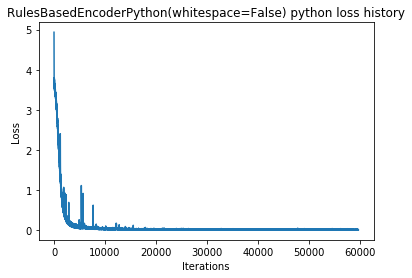

In [3]:
models = [ (RulesBasedEncoder(), .0001, python_dat, 'python')]
loaded_models = load_models(models)

for (encoder, decoder, alphabet, lang, loss_history) in loaded_models:
    plt.title('{} {} loss history'.format(encoder.name(), lang))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(loss_history)
    plt.show()

We can run the trained decoder on some examples.

In [4]:
def run_models_on_string(string, models,beam=False):
    for model in models:
        (encoder, decoder, alphabet, language, _) = model
        print(encoder, "\n", decoder([string], alphabet)[0],"\n") 
        if beam:
            print(beam_search_predictions(decoder, string, alphabet, beam_size=2),"\n")

run_models_on_string("for i in rng(10):", loaded_models)
run_models_on_string("for i in rg(10):", loaded_models)

 for i in range(10): 

 for i in rg(10): 



This works for the abbreviation 'rng', because it was explicitly in the translation list.
But if the abbreviation is not on the list, the decoder struggles: clearly this is not going to scale.
We want our model to be flexible with respect to the various encodings that a programmer might use.

One way to ensure flexibility is to separately decide whether to drop each character with some fixed probability. 

In [5]:
models = [
    (UniformEncoder(removal_probability=.8),.0005, python_dat, 'python')
]

loaded_models = load_models(models)

Model UniformEncoder(0.80) python loaded!


In [6]:
run_models_on_string("for i in rng(10):", loaded_models)

 for i in range(10): 



In [7]:
run_models_on_string("for i in rg(10):", loaded_models)

 for i in range(10): 



The uniform distribution encoding works to train a decoder which can solve both our original example and the perturbed one.
 
But it seems like we are missing something in our model of human line compression. Certain characters are more likely to be dropped in accordance with how redundant they are semantically. One way of approximating this is to iteratively drop the most-common n-grams in the corpus. To keep the learning reasonable, we don't drop the first and last charaters of the n-gram.

In [8]:
models = [
   (UniformEncoder(removal_probability=.8),.0005, python_dat, 'python'),
   (FrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python')    
]

loaded_models = load_models(models)

Model UniformEncoder(0.80) python loaded!
Model FrequencyEncoder(5-gram, target_size:0.8) python loaded!


In [9]:
run_models_on_string('per._opn("-v", "--vern", help="use a specific zc.bdout vern")', loaded_models, beam=False)

 per._open("-v", "--version", help="user a specific zc.bad out version") 

 parser.add_option("-v", "--version", help="use a specific zc.buildout version") 



The frequency-based decoder gets this example correct. The common 5-grams that were identified in the original string were 'parse', '.add_', 'ption', 'rsion', 'build', and 'rsion' again. The uniform case is working off of more local information and cannot reconstruct 'zc.buildout' from 'zc.bdout'.

But if we look back at our range example, we find that the frequency-based encoding badly misbehaves:

In [12]:
run_models_on_string("for i in rng(10):", loaded_models)

 for i in range(10): 

 for i in rng(10000): 



The frequency-based decoder sees 10, and guesses that it really comes from the sequence 10000.
Even worse, in the beam search the number is further expanded because it thinks that 00 comes from 00000. 

This could be due to the decoder learning that it needs to expand the input string, and will prefer longer explanations as a result.
Frequency-based can sometimes build sophisticated translations using fairly non-local information; however, it tends to violate Occam's Razor.

How should we evaluate these models? Accuracies of models using their own encoding schemes are somewhat incomparable -- we also need to know which of the encoding schemes is closest to what programmers would actually type when using these autocompletion facilities.

Maybe we can get more information by comparing how the decoders work using each others' encoders.

In [16]:
models = [
   (RulesBasedEncoder(), .0001, python_dat, 'python'),
   (UniformEncoder(removal_probability=.8),.0005, python_dat, 'python'),
   (FrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python')    
]
loaded_models = load_models(models)

Model RulesBasedEncoderPython(whitespace=False) python loaded!
Model UniformEncoder(0.80) python loaded!
Model FrequencyEncoder(5-gram, target_size:0.8) python loaded!


In [17]:
def top1_accuracy(encoder, decoder, alphabet, dataset):
    return len(list(filter(lambda x:x[0]==x[1],
                          zip(dataset, decoder(encoder.encode_batch(dataset),alphabet))))) / len(dataset)

def models_to_name(m1,m2):
    return str((m1[0].name()+m1[3], m2[0].name()+m2[3]))

def models_to_accuracy(m1,m2,dataset,accuracy_metric):
    (encoder, _, _, _, _), (_, decoder, alphabet, _, _) = m1, m2
    return accuracy_metric(encoder, decoder, alphabet, dataset)

def accuracy_table(models, dataset, accuracy_metric=top1_accuracy):
    d = {}
    for m1 in models:
        for m2 in models:
            d[models_to_name(m1,m2)] = \
                models_to_accuracy(m1,m2,dataset,accuracy_metric) 
    return d
    
def visual_accuracy_table(models, dataset, accuracy_metric=top1_accuracy):
    return pandas.DataFrame(
            np.array([[models_to_accuracy(m1,m2,dataset,accuracy_metric) for m2 in models]
                      for m1 in models]), 
            columns = [m[0].name()+m[3] for m in models],
            index = [m[0].name()+m[3] for m in models])



In [18]:
#row labels correspond to the encoder, and column labels correspond to the decoder
visual_accuracy_table(loaded_models,full_dataset['python']['test'][:100])

,RulesBasedEncoderPython(whitespace=False)python,UniformEncoder(0.80)python,"FrequencyEncoder(5-gram, target_size:0.8)python"
RulesBasedEncoderPython(whitespace=False)python,0.97,0.59,0.19
UniformEncoder(0.80)python,0.00,0.21,0.01
"FrequencyEncoder(5-gram, target_size:0.8)python",0.00,0.09,0.69


Rule-based decodes its own encodings nearly perfectly, but cannot decode uniform or frequency -- it is overfitting to its own very simple encodings. We can see the simplicity of the rule-based encodings in the high uniform and frequency based decoding scores.

The uniform decoder performs meagerly on its on encodings, but also performs non-negligibly on rule and frequency based encodings.

Contrast this with the frequency decoder. It does well on itself and partially figures out rule-based, but it completely fails on uniform encodings. The frequency decoder is inflexible -- a small perterbation causes it to leave the regime where it can give confident predictions. This is because the frequency encoder is forced to only consider fixed deletions of n-grams in a fixed order, given by relative n-gram frequencies in the dataset.

We can find a middle ground between the under and over fitting of uniform and frequency based encoders respectively by introducing noise into the frequency encoding:
Each time an n-gram would be deleted instead flip a fair coin. If heads then continue normally, otherwise delete a random character. This allows the frequency encoder to generate greater variation during training, while not drowning out the benefits of preferentially deleting redundant characters.

In [19]:
models = [
   (RulesBasedEncoder(), .0001, python_dat, 'python'),
   (UniformEncoder(removal_probability=.8),.0005, python_dat, 'python'),
   (FrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python'),    
   (FuzzyFrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python')
]
loaded_models = load_models(models)

Model RulesBasedEncoderPython(whitespace=False) python loaded!
Model UniformEncoder(0.80) python loaded!
Model FrequencyEncoder(5-gram, target_size:0.8) python loaded!
Model FuzzyFrequencyEncoder(5-gram, target_size:0.8) python loaded!


In [20]:
visual_accuracy_table(loaded_models,full_dataset['python']['test'][:200])

,RulesBasedEncoderPython(whitespace=False)python,UniformEncoder(0.80)python,"FrequencyEncoder(5-gram, target_size:0.8)python","FuzzyFrequencyEncoder(5-gram, target_size:0.8)python"
RulesBasedEncoderPython(whitespace=False)python,0.940,0.640,0.185,0.160
UniformEncoder(0.80)python,0.010,0.160,0.005,0.070
"FrequencyEncoder(5-gram, target_size:0.8)python",0.005,0.080,0.645,0.035
"FuzzyFrequencyEncoder(5-gram, target_size:0.8)python",0.000,0.015,0.000,0.230


Now we have a decoder that performs well enough on rules and uniform, but also performs better than uniform on its own encodings.

These metrics are helpful, but to really get a feel for the efficacies of these learned decoders we will need to see examples.  

In [21]:
run_models_on_string("for i in rng(10):", loaded_models, beam=True)

 for i in range(10): 

['for i in range(10):', 'for i in range(10):]'] 

 for i in range(10): 

['for i in range(10):', 'for i in range(100):'] 

 for i in rng(10): 

['for i in rng(10000):', 'for i in rng(10):'] 

 for i in range(10): 

['for i in range(10):', 'for i in range(100):'] 



In [24]:
run_models_on_string("r i i r10):", loaded_models, beam=True)

 r i i r10): 

['r i i r10):', 'r i i  0):'] 

 for i in r100000000000000000): 

['for i in r10):', 'for i in r1000000):'] 

 rul, i == r10): 

['rum, i in r10):', 'run, i in r10):'] 

 for i in range(10): 

['for i in range(10):', 'for i in range(1,0):'] 



The decoders that do the right sort of thing in practice are uniform and fuzzy frequency, even though fuzzy frequency didn't come out amazingly well in the above accuracies. In the last example, the n-gram training helps FuzzyFrequencyEncoder recover the full word 'range' from just 'r'. 
The extra ability of uniform and fuzzy frequency will come out clearer when evaluating on whether the correct answer is in the top five predictions.

In [18]:
def top5_accuracy(encoder, decoder, alphabet, dataset):
    count = 0
    for string in dataset:
        compressed = encoder.encode(string)
        best_five = beam_search_predictions(decoder, compressed, alphabet, beam_size=5)
        if string in best_five: count += 1
    return float(count) / len(dataset)

visual_accuracy_table(loaded_models,full_dataset['python']['test'][:200],top5_accuracy)

,RulesBasedEncoderPython(whitespace=False)python,UniformEncoder(0.80)python,"FrequencyEncoder(5-gram, target_size:0.8)python","FuzzyFrequencyEncoder(5-gram, target_size:0.8)python"
RulesBasedEncoderPython(whitespace=False)python,0.980,0.805,0.385,0.450
UniformEncoder(0.80)python,0.015,0.340,0.010,0.250
"FrequencyEncoder(5-gram, target_size:0.8)python",0.005,0.270,0.765,0.115
"FuzzyFrequencyEncoder(5-gram, target_size:0.8)python",0.000,0.060,0.000,0.410


Indeed, fuzzy frequency has a wider support in the top 5 accuracy model, and edges out uniform in self-accuracy. But if anything this chart further affirms the accuracy of the plain old uniform encoder.

-- Put in a section here if the scheduled uniform or .6 uniform does well --

Let's finish off by showing the uniform and fuzzy frequency decoders at their best and worst.

In [19]:
models = [
   (UniformEncoder(removal_probability=.8),.0005, python_dat, 'python'),
   (FuzzyFrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python')
]
loaded_models = load_models(models)

Model UniformEncoder(0.80) python loaded!
Model FuzzyFrequencyEncoder(5-gram, target_size:0.8) python loaded!


In [20]:
BATCH_SIZE = 128

def reset_seeds():
    # Set seed before computing accuracy to make the encoders deterministic.
    np.random.seed(224)
    random.seed(224)
    torch.manual_seed(224)
    
def batched_decode_all(model, dataset):
    reset_seeds()
    (encoder, decoder, alphabet, _, _) = model
    encoded_strings = [encoder.encode(s) for s in dataset]
    decoded = []    
    for i in range((len(dataset) + BATCH_SIZE - 1) // BATCH_SIZE):
        decoded.extend(decoder(encoded_strings[i*BATCH_SIZE:(i+1)*BATCH_SIZE], alphabet))
    return list(zip(dataset, encoded_strings, decoded))

def best_example(model, dataset, k=1):
    correct = list(filter(lambda x: x[0]==x[2],
                          batched_decode_all(model, dataset)))
    correct_with_fxn = [(c[1],c[2],len(c[0])-len(c[1])) for c in correct]
    return sorted(correct_with_fxn, key=lambda x: -x[2])[:k]

def worst_example(model, dataset, k=1):
    incorrect = list(filter(lambda x: x[0]!=x[2],
                          batched_decode_all(model, dataset)))
    incorrect_with_fxn = [(c[0],c[1],c[2],len(c[0])-len(c[1])) for c in incorrect]
    return sorted(incorrect_with_fxn, key=lambda x: x[3])[:k]

In [21]:
unif8 = loaded_models[0]
# prints (encoded, decoded, difference in length between original and compressed)
print(best_example(unif8, full_dataset['python']['test'][:1000])[0],"\n")
# prints (original, encoded, decoded, different in length between original and compressed)
print(worst_example(unif8, full_dataset['python']['test'][:1000])[0])

('BASEPTH = o.ath.dirnamo.patabpath__fil_))', 'BASE_PATH = os.path.dirname(os.path.abspath(__file__))', 13) 

('tod_ = smm.tod', 'tod_ = smm.tod', 'todo_ = smm.todo', 0)


In [22]:
ffreq8 = loaded_models[1]
# prints (encoded, decoded, difference in length between original and compressed)
print(best_example(ffreq8, full_dataset['python']['test'][:1000])[0],"\n")
# prints (original, encoded, decoded, different in length between original and compressed)
print(worst_example(ffreq8, full_dataset['python']['test'][:1000])[0])

("fotcreator = os.os.pth.dirnme(___), '..', fontcreator.py')", "fontcreator = os.path.join(os.path.dirname(__file__), '..', 'fontcreator.py')", 19) 

('coord = []', 'ood = []', 'ood_list = []', 2)


A final note -- if I was using this project for autocompletion in the wild, I would use either fuzzy frequency 0.8 or uniform 0.7. I did not bring up uniform 0.7 during the explanation because it performs slightly worse than 0.8 on our metrics.

However, when looking at the output, it is able to get common-sense answers more of the time, and it is clear that it has to learn more of a language model in order to autocomplete with so many characters missing. Top 1 and top 5 accuracies are still missing an important piece of the evaluation for this project. We also considered a way to measure distance from desired string and use that as a metric, but we do not think this will give more clarity into the quality of encoder/decoder pairs.

We might be able to quantify the performance of fuzzy frequency 0.8 and uniform 0.7 by using a language model on the translations, but this seems out of scope for our current effort. 

We also tried uniform 0.6 and a uniform curriculum where we decrease the probability of keeping characters during training. These led to some reasonable but not outstanding translations. I think it would be difficult to do much better than uniform 0.7 and fuzzy frequency 0.8 for translation through further ad-hoc methods. I would not be surprised if successfully learning the encoder and decoder simultaneously would lead to significantly better performance.